## This notebook is part of self learning Quantum Computing Algorithms

## Description: This program simulates monte carlo method

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

In [2]:
#import stock data
def import_stock_data(tickers, start):
    data = pd.DataFrame()
    if len([tickers]) == 1:
        data[tickers] = wb.DataReader(tickers, data_source = 'yahoo', start = start)['Adj Close']
        data = pd.DataFrame(data)
    else:
        for ticker in tickers:
            data[ticker] = wb.DataReader(ticker, data_source = 'yahoo', start = start)['Adj Close']
    return data

In [3]:
import_stock_data('GOOG', '2021-1-1')

,GOOG
Date,
2020-12-31,1751.880005
2021-01-04,1728.239990
2021-01-05,1740.920044
2021-01-06,1735.290039
2021-01-07,1787.250000
...,...
2021-08-26,2842.459961
2021-08-27,2891.010010
2021-08-30,2909.389893


In [4]:
def log_returns(data):
    return (np.log(1+data.pct_change()))

In [5]:
log_returns(import_stock_data('GOOG', '2021-1-1'))

,GOOG
Date,
2020-12-31,NaN
2021-01-04,-0.013586
2021-01-05,0.007310
2021-01-06,-0.003239
2021-01-07,0.029504
...,...
2021-08-26,-0.005802
2021-08-27,0.016936
2021-08-30,0.006337


In [6]:
def market_data_combination(data, start, mark_ticker = "^GSPC"):
    market_data = import_stock_data(mark_ticker, start)
    market_rets = log_returns(market_data).dropna()
    ann_return = np.exp(market_rets.mean()*252).values - 1
    data = data.merge(market_data, left_index=True, right_index=True)
    return data, ann_return

In [7]:
market_data_combination(import_stock_data('GOOG', '2021-1-1'), '2021-1-1')

(                   GOOG        ^GSPC
 Date                                
 2020-12-31  1751.880005  3756.070068
 2021-01-04  1728.239990  3700.649902
 2021-01-05  1740.920044  3726.860107
 2021-01-06  1735.290039  3748.139893
 2021-01-07  1787.250000  3803.790039
 ...                 ...          ...
 2021-08-26  2842.459961  4470.000000
 2021-08-27  2891.010010  4509.370117
 2021-08-30  2909.389893  4528.790039
 2021-08-31  2909.239990  4522.680176
 2021-09-01  2916.840088  4524.089844
 
 [169 rows x 2 columns],
 array([0.321893]))

## Beta of every stock 
## $\beta_{i} = \frac{\text{Cov(m, i)}}{Var(m)} = \frac{\sigma_{i, m}}{\sigma^{2}_{m}}\\ \text{where,} \\ \text{i, is the returns on our portfolio or stock - DEPENDENT VARIABLE} \\ \text{m, is the market returns or index - INDEPENDENT VARIABLE} \\ \text{Variance is the square of standard deviation.}$

In [8]:
def beta(data, dd, start):
    log_return = log_returns(dd)
    covar = log_return.cov()*252
    covar = pd.DataFrame(covar.iloc[:-1,-1])
    market_var = log_return.iloc[:,-1].var()*252
    beta = covar/market_var
    
    stdev_return = pd.DataFrame(((log_return.std()*250**0.5)[:-1]), columns=['STD'])
    beta = beta.merge(stdev_return, left_index=True, right_index=True)
    return beta

In [9]:
dd, mark_return = market_data_combination(import_stock_data('GOOG', '2021-1-1'), '2021-1-1')
beta(import_stock_data('GOOG', '2021-1-1'), dd, '2021-1-1')

,^GSPC,STD
GOOG,1.290836,0.236773


## CAPM
## $E(R_{i}) = R_{f} + \beta_{i}(E(R_{m}) - R_{f}) \\ \text{where,} \\ 
E(R_{i})=\text{capital asset expected return} \\
R_{f}=\text{risk-free rate of interest} \\
\beta_i=\text{sensitivity} \\
E(R_{m})=\text{expected return of the market}$

In [10]:
def capm(beta, mark_return, riskfree = 0.025, mark_ticker = "^GSPC"):
    for i, row in beta.iterrows():
        beta.at[i,'CAPM'] = riskfree + (row[mark_ticker] * (mark_return - riskfree))
    return beta

In [11]:
capm(beta(import_stock_data('GOOG', '2021-1-1'), dd, '2021-1-1'), mark_return)

,^GSPC,STD,CAPM
GOOG,1.290836,0.236773,0.40824


## Sharpe
## $\text{Sharpe} = \frac{E(R_{i}) - R_{f}}{\sigma_{i}} \\ \text{Where,} \\ E = \text{expected return} \\ R_{i} = \text{asset return} \\ R_{f} = \text{risk free return} \\ \sigma_{i} = \text{standard deviation of the asset}$

In [12]:
def sharpe(beta, riskfree = 0.025):
    for i, row in beta.iterrows():
        beta.at[i,'Sharpe'] = ((row['CAPM'] - riskfree)/(row['STD']))
    return beta

In [13]:
sharpe(capm(beta(import_stock_data('GOOG', '2021-1-1'), dd, '2021-1-1'), mark_return))

,^GSPC,STD,CAPM,Sharpe
GOOG,1.290836,0.236773,0.40824,1.618599


In [14]:
def beta_sharpe(data, start, mark_ticker = "^GSPC", riskfree = 0.025):
    
    """
    mark_ticker: ticker of the market data you want to compute CAPM metrics with (default is ^GSPC)
    riskfree: the assumed risk free yield (US 10 Year Bond is assumed: 2.5%)
    """
    dd, mark_return = market_data_combination(data, start, mark_ticker)
    beta_v = beta(data, dd, start)
    beta_v = capm(beta_v, mark_return, riskfree, mark_ticker)
    beta_v = sharpe(beta_v, riskfree)
    beta_v.rename(columns={"^GSPC":"Beta"}, inplace=True)
    return beta_v

In [15]:
beta_sharpe(import_stock_data('GOOG', '2021-1-1'), '2021-1-1')

,Beta,STD,CAPM,Sharpe
GOOG,1.290836,0.236773,0.40824,1.618599


## $\text{drift} = \mu - \frac{1}{2} \sigma^{2} \\ \text{where} \\ \mu = \text{mean} \\ \sigma^{2} = \text{Variance}$

In [16]:
def drift_calc(data):
    lr = log_returns(data)
    u = lr.mean()
    var = lr.var()
    drift = u-(0.5*var)
    try:
        return drift.values
    except:
        return drift

In [17]:
drift_calc(import_stock_data('GOOG', '2021-1-1'))

array([0.00292247])

## $\text{Volatility} = \sigma Z \\ \text{where} \\ \sigma = \text{standard deviation} \\ Z \in (0, 1), \ Z = rand(0, 1)$

In [18]:
def volatility_calc(data, days, iterations):
    try:
        stdev = log_returns(data).std().values
    except:
        stdev = log_returns(data).std()
    #Returns random variables between 0 and 1
    x = np.random.rand(days, iterations) #days, trials
    #Percent Point Function - the inverse of a CDF
    Z = norm.ppf(x) 
    volatility = stdev * Z
    return volatility

In [19]:
volatility_calc(import_stock_data('GOOG', '2021-1-1'), 50, 10000)

array([[ 0.01471526,  0.00632707,  0.00922844, ...,  0.02106161,
        -0.01848568,  0.02282442],
       [ 0.00018589, -0.01334159, -0.00020717, ..., -0.01134867,
        -0.00159244, -0.01482993],
       [ 0.00979944, -0.0269518 , -0.01212855, ...,  0.00433605,
         0.00655773, -0.0048826 ],
       ...,
       [-0.04856118, -0.04061219,  0.01681762, ...,  0.02728513,
         0.01129889,  0.02311516],
       [ 0.02354229, -0.0070042 , -0.00416017, ...,  0.01223337,
         0.00519698, -0.0163079 ],
       [ 0.00780029, -0.01215869, -0.01991242, ...,  0.01017364,
         0.00800185, -0.01189314]])

## $\text{Daily returns} \\ e^{r} = e^{\text{drift} + \text{volatility}}$

In [20]:
def daily_returns(data, days, iterations):
    ft = drift_calc(data)
    vol = volatility_calc(data, days, iterations)
    dr = np.exp(ft + vol)
    return dr

In [21]:
daily_returns(import_stock_data('GOOG', '2021-1-1'), 50, 10000)

array([[0.98270446, 1.00856513, 0.99667728, ..., 1.00697853, 0.98769626,
        1.00631803],
       [0.98803135, 0.98941062, 0.99312635, ..., 1.00394302, 1.01378838,
        1.00389413],
       [0.99200202, 0.99475818, 0.98046292, ..., 1.01297502, 0.99177479,
        0.99672463],
       ...,
       [0.9876919 , 0.99826357, 1.03037699, ..., 1.00635099, 1.0347682 ,
        0.97679556],
       [1.00764031, 1.01932659, 0.98966693, ..., 1.03559482, 0.99311976,
        0.99511601],
       [0.99841545, 0.98185952, 1.02581107, ..., 0.99229501, 1.01138296,
        1.02796403]])

## $\text{price today} = \text{price yesterday} * e^{r} \\ s_{t} = s_{t-1} * e^{r} \\ r = \text{drift + volatility}$

In [22]:
def price_list(data, days, iterations):
    dr = daily_returns(data, days, iterations)
    # Create empty matrix
    price_list = np.zeros_like(dr)
    # Put the last actual price in the first row of matrix. 
    price_list[0] = data.iloc[-1]
    # Calculate the price of each day
    for t in range(1, days):
        price_list[t] = price_list[t - 1] * dr[t]
    return price_list

In [23]:
price_list(import_stock_data('GOOG', '2021-1-1'), 50, 10000)

array([[2916.84008789, 2916.84008789, 2916.84008789, ..., 2916.84008789,
        2916.84008789, 2916.84008789],
       [2877.70186954, 2854.69352267, 2916.71617522, ..., 2850.89690781,
        2935.53977283, 2956.87371969],
       [2839.85541333, 2867.55341503, 2857.11244926, ..., 2930.44356407,
        2997.65214249, 2973.07958587],
       ...,
       [3424.54906252, 3328.20572489, 3316.62128514, ..., 3245.76823881,
        3713.82681046, 2687.2489575 ],
       [3470.2250952 , 3322.12305058, 3321.96283304, ..., 3278.71660707,
        3722.12011178, 2685.01496152],
       [3445.18605758, 3327.35583903, 3316.07275367, ..., 3237.98910486,
        3698.78818927, 2729.07451706]])

In [24]:
def probs_find(predicted, higherthan):
    """
    This function calculate the probability of a stock being above a certain threshhold, 
    which can be defined as a return rate (percentage change)
    """
    predicted0 = predicted.iloc[0,0]
    predicted = predicted.iloc[-1]
    predList = list(predicted)
    over = list()
    less = list()
    for i in predList:
        pred_pct = (i*100)/predicted0
        curr_pred = pred_pct - 100
        if curr_pred >= higherthan:
            over.append(pred_pct)
        else:
            less.append(pred_pct)     
    return (len(over)/(len(over)+len(less)))

In [25]:
probs_find(pd.DataFrame(price_list(import_stock_data('GOOG', '2021-1-1'), 50, 10000)), 0)

0.9192

In [26]:
def simulate_monte_carlo(data, days, iterations):
    price_list_v = price_list(data, days, iterations)
    x = pd.DataFrame(price_list_v).iloc[-1]
    fig, ax = plt.subplots(1,2, figsize=(14,4))
    sns.distplot(x, ax=ax[0])
    sns.distplot(x, hist_kws={'cumulative':True}, kde_kws={'cumulative':True}, ax=ax[1])
    plt.xlabel("Stock Price")
    plt.show()
    try:
        [print(nam) for nam in data.columns]
    except:
        print(data.name)
    print(f"Days: {days - 1}")
    print(f"Expected Value: ${round(pd.DataFrame(price_list_v).iloc[-1].mean(),2)}")
    print(f"Return: {round(100*(pd.DataFrame(price_list_v).iloc[-1].mean()-price_list_v[0,1])/pd.DataFrame(price_list_v).iloc[-1].mean(),2)}%")
    print(f"Probability of Breakeven: {probs_find(pd.DataFrame(price_list_v),0)}")
    return pd.DataFrame(price_list_v)

c:\users\bala.na\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\bala.na\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


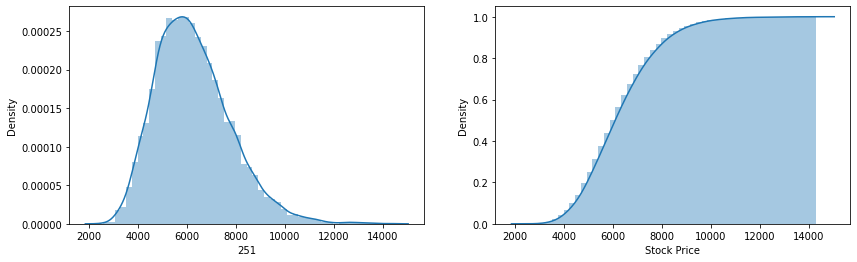

GOOG
Days: 251
Expected Value: $6257.17
Return: 53.38%
Probability of Breakeven: 0.9994


,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,2916.840088,2916.840088,2916.840088,2916.840088,2916.840088,2916.840088,2916.840088,2916.840088,2916.840088,2916.840088,...,2916.840088,2916.840088,2916.840088,2916.840088,2916.840088,2916.840088,2916.840088,2916.840088,2916.840088,2916.840088
1,2983.088715,2891.316698,2956.110312,3007.152544,2838.950157,2980.712146,3000.975843,2908.898359,2856.611351,2847.847225,...,2945.143378,2967.084668,2914.562448,2875.262935,2950.567039,2960.448131,2990.250088,2942.320527,2888.420625,2935.844303
2,3012.301027,2952.397839,2937.298049,2995.174278,2851.576576,2928.428595,3004.270394,2935.327371,2819.541248,2799.297411,...,3029.205832,3026.423353,2918.195484,2871.920058,2965.979019,2907.441146,3000.327506,2919.389577,2949.419284,2985.132296
3,3005.410753,2917.728987,3014.790393,2998.740519,2797.999153,2879.276273,3057.035564,2967.782321,2806.947152,2757.543274,...,3013.070866,3038.889193,2896.495975,2857.439136,3052.674774,2986.111295,2959.972704,2931.226839,2975.542962,2987.813456
4,2989.125380,2948.453301,3007.783245,3037.778378,2776.701442,2897.268208,3087.169068,2997.005058,2801.688506,2751.749149,...,2998.152038,3027.275896,2923.146782,2878.607549,3073.524241,2956.159911,2934.430921,2942.236149,3043.539948,3060.047743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,5733.678774,10059.694806,5620.286407,6637.408050,4945.173611,5876.062280,9277.709112,6976.612708,6308.068135,6619.398212,...,6230.889453,7918.036851,6179.376382,4901.729836,11671.177890,6858.498604,7003.220268,6335.892813,5709.938804,6280.655934
248,5830.080186,10155.723087,5675.725781,6655.518251,5016.807237,5743.811577,9341.680208,7026.168577,6396.358452,6613.778790,...,6266.953378,7939.317252,6205.069174,5048.515410,11744.135974,6920.348169,6949.466765,6296.961746,5660.150259,6372.499386
249,5676.180014,10359.346269,5645.977606,6593.543911,4923.942327,5681.342477,9362.828359,6852.207578,6411.287748,6471.247946,...,6255.095870,8070.581359,6149.624150,5025.821442,11715.547744,6784.682608,7115.068207,6274.365244,5810.015296,6396.548701
250,5569.119204,10035.343130,5533.728268,6620.188354,4872.059708,5684.937214,9373.247909,6819.771820,6448.831170,6444.761119,...,6095.637375,7913.141656,6035.248497,5110.748396,11693.734591,6915.309047,7204.411482,6112.289072,5842.393023,6325.054890


In [27]:
simulate_monte_carlo(import_stock_data('GOOG', '2021-1-1'), 252, 10000) 

In [28]:
def monte_carlo(tickers, days_forecast, iterations, start_date, mark_ticker="^GSPC", riskfree = 0.025):
    data = import_stock_data(tickers, start_date)
    inform = beta_sharpe(data, start_date, mark_ticker="^GSPC")
    simulatedDF = []
    for ticker in range(len(tickers)):
        y = simulate_monte_carlo(data.iloc[:, ticker], days_forecast+1, iterations) 
        forplot = y.iloc[:,0:10]
        forplot.plot(figsize=(15,4))
        print(f"Beta: {round(inform.iloc[ticker, inform.columns.get_loc('Beta')], 2)}")
        print(f"Sharpe: {round(inform.iloc[ticker, inform.columns.get_loc('Sharpe')], 2)}") 
        print(f"CAPM Return: {round(100*inform.iloc[ticker, inform.columns.get_loc('CAPM')], 2)}%")
        y['ticker'] = tickers[ticker]
        cols = y.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        y = y[cols]
        simulatedDF.append(y)
    simulatedDF = pd.concat(simulatedDF)
    return simulatedDF

c:\users\bala.na\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\bala.na\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


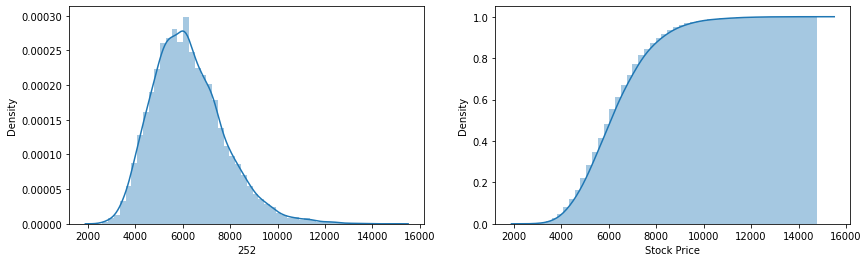

GOOG
Days: 252
Expected Value: $6248.09
Return: 53.32%
Probability of Breakeven: 0.9987
Beta: 1.29
Sharpe: 1.62
CAPM Return: 40.82%


c:\users\bala.na\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\bala.na\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


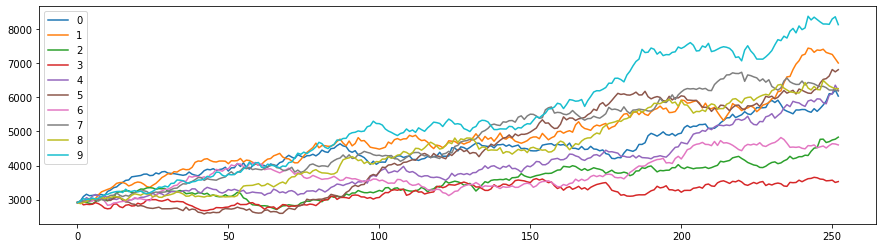

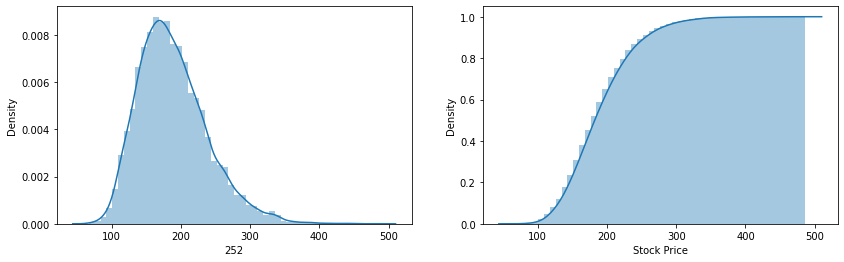

AAPL
Days: 252
Expected Value: $188.43
Return: 19.06%
Probability of Breakeven: 0.7511
Beta: 1.4
Sharpe: 1.62
CAPM Return: 44.09%


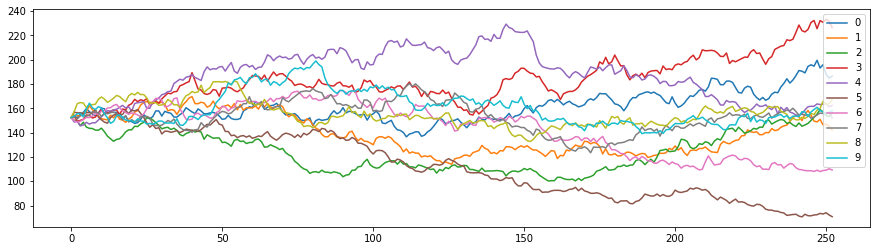

In [29]:
ret_sim_df = monte_carlo(['GOOG','AAPL'], 252, 10000,  '2021-1-1', mark_ticker="^GSPC", riskfree = 0.025)

In [30]:
ret_sim_df

,ticker,0,1,2,3,4,5,6,7,8,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
0,GOOG,2916.840088,2916.840088,2916.840088,2916.840088,2916.840088,2916.840088,2916.840088,2916.840088,2916.840088,...,2916.840088,2916.840088,2916.840088,2916.840088,2916.840088,2916.840088,2916.840088,2916.840088,2916.840088,2916.840088
1,GOOG,2964.155433,2932.296437,2914.399796,2937.943555,2923.945366,2958.256313,2916.084481,2931.161677,2882.403573,...,3001.305161,2922.588294,2864.948112,2947.144809,2958.361850,2992.087200,2905.348023,2969.210148,2990.966025,2949.633928
2,GOOG,3092.182465,2960.605339,2930.571987,2848.567370,2945.804225,2974.193007,2959.477382,2955.845443,2915.365587,...,2994.909122,2974.921547,2904.950157,3007.345004,2908.762983,2971.424697,2908.290266,2971.401945,2979.247675,2938.226506
3,GOOG,3158.728556,2948.748230,2917.792286,2864.921612,3060.150022,2971.538282,2995.451876,2962.623392,2944.716363,...,2986.787775,2974.416333,2946.735336,2979.385002,2918.994457,2949.713520,2901.469090,3007.910488,2980.464464,2863.511409
4,GOOG,3115.276916,2998.324493,2891.983114,2857.852479,3009.486390,3029.323693,2950.590441,2958.983634,3024.652489,...,3046.116264,2944.877331,2957.402772,2983.498360,2948.276379,2998.549847,2992.087771,2973.278030,2977.127611,2838.912130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,AAPL,193.231209,150.966205,158.992823,232.196432,163.119276,73.667749,108.080933,156.145604,160.039183,...,192.415015,108.839325,203.546028,122.768778,154.165731,159.329781,207.184509,204.681609,178.836027,299.947544
249,AAPL,195.968180,146.403041,157.037538,230.701501,163.519810,73.161166,108.921264,155.784350,165.841033,...,190.257750,111.664720,204.038277,120.426863,151.946760,158.316667,208.794256,206.418470,176.183476,303.053217
250,AAPL,187.883735,147.129278,153.983195,233.286957,163.668532,74.172101,109.206520,156.571045,163.370854,...,192.985569,111.981047,202.369625,120.317357,150.412749,157.140530,212.201177,207.377749,178.416472,295.463633
251,AAPL,184.881291,145.163115,153.391107,231.501001,161.240806,72.361880,110.351957,156.406793,163.742828,...,198.103235,113.598324,204.102701,119.037669,152.735466,157.572067,213.133920,205.805492,186.680788,292.220995


## If you have any queries on this notebook please reach to me bala.na@hcl.com